# BarcodeBabel draft 7

Elliot Eton
<br>
August 2020
<br>
Contact: eoe4001@med.cornell.edu

Rules:
1. User-defined enzyme cleavage sites
    * Defaults: `GRA` on both ends
    * Specify separately for beginning and end
    * Enzyme function needs to be edited to match user cleavage site
2. User-defined frequencies of amino acids:
    * Defaults: Frequencies will be 0 for some: K, R, H, C, M, P
3. User-defined m/z range at user-defined pH
    * Defaults: pH = 3, m/z range: 550-850
4. User-defined maximum length of allowed repeats
    * Default: 2
5. User-defined hydrophobicity range:
    * Default: Updated with proteometools hydrophobicity range - max hydrophobic windows
6. User-defined library size:
    * Default: 2000
7. Disallow overlap with reference proteome
    
Properties 3 and 5 must be satisfied by the trypsinized barcode (e.g. instead of computing `property("GRAxxxGRA")` we want to compute `property("AxxxGR")`)

## 0. Import packages

In [4]:
import sys, getopt
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio import SeqIO
from Bio import Seq
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint, positive_pKs, negative_pKs
import matplotlib.pyplot as plt
import csv
from datetime import datetime

## 1. Allow user to start BarcodeBabel through Terminal and access the provided input file.

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

def error_message(argv):
    print('Please specify an input file.')
    print('Format: SCRIPT.py -i <inputfile>')
    
def obtain_file(argv):
    '''This function will detect whether an input file containing the script parameters
    has been provided by the user. If provided, script will save the name of the input file
    for use. If not provided, script will shutdown and display an error message.'''
    inputfile = ''
    if len(sys.argv) <= 1:
        error_message(1)
        sys.exit(1)
    try:
        opts, args = getopt.getopt(argv,"hi:o:",["ifile="])
    except getopt.GetoptError:
        error_message(1)
        sys.exit(2)
    for opt, arg in opts:
        if opt == '-h':
            error_message(1)
            sys.exit()
        if opt in ("-i", "--ifile"):
            inputfile = arg
    print('Welcome to BarcodeBabel, version 8.')
    print('\n')
    print('Accessing the input file: ' + str(inputfile) + '...')
    print('Success: input file ' + str(inputfile) + ' accessed.')
    print('\n')
    return inputfile

if __name__ == "__main__":
    inputfile = obtain_file(sys.argv[1:])

## 2. Parse input file.

### 2.1 Read file and save the user-defined parameter values. 

In [ ]:
print("Reading the input file " + str(inputfile) + "...")

In [3]:
inputfile = "inputfile.csv" #####*****Just for jupyter notebook*****#####

#parse excel sheet
params = pd.read_csv(inputfile)
#drop empty columns
params.drop(params.columns[params.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
#for consistency, capitalize all characters in column headers
params.rename(columns=str.upper, inplace = True)
#replace all extraneous characters
params.columns = params.columns.str.strip('-\xd0./_')
params.columns = params.columns.str.replace("_", "")
#for all cells where NaN, fill with 0.00
params = params.fillna(0.00)
#convert the dataframe containing the user defined parameters to a dict for easy use
user_defined_params = params.to_dict('list')
#the values in that dict are lists...convert to strings
user_params = {}
for key in user_defined_params:
    user_params[key] = str(user_defined_params[key][0])

In [ ]:
print("Success: input file " + str(inputfile) + " read.")
print('\n')

### 2.2 Evaluate and compile (if needed) user-defined parameters with package defaults.

In [ ]:
print("Evaluating user-defined parameters...")

In [4]:
#a list of all possible parameters that the user can specify
poss_params = [
                'CUT SITE 1',
                'CUT SITE 2',
                'LENGTH',
                'DIGEST',
                'SIDE',
                'A', 
                'C', 
                'D',
                'E', 
                'F',
                'G',
                'H',
                'I', 
                'K', 
                'L', 
                'M', 
                'N', 
                'P', 
                'Q', 
                'R', 
                'S', 
                'T', 
                'V', 
                'W', 
                'Y', 
                'PH', 
                'MZMIN', 
                'MZMAX', 
                'REP', 
                'HMIN', 
                'HMAX', 
                'REF', 
                'LIB']

#a list of the default parameters
defaults = {
                'CUT SITE 1': 'GRA',
                'CUT SITE 2': 'GRA',
                'LENGTH': 3, #need to adjust depending on length of cut site
                'DIGEST': 'R',
                'SIDE':'C',
                #K,R,H can cause trypsin cleavage within sequences
                'K': 0.00,
                'R': 0.00,
                'H': 0.00,
                #C,M can be oxidized
                'C': 0.00,
                'M': 0.00,
                #P skews fragmentation
                'P': 0.00,
                #I,L cannot be distinguished
                'I': 0.00,
                'L': 0.00,
                #Q,N can be easily deamidated
                'Q': 0.00,
                'N': 0.00,
                'PH': 3,
                'MZMIN': 550,
                'MZMAX': 850,
                'REP': 2,
                'HMIN': -0.5,
                'HMAX': 2.5,
                'REF': 0.0,
                'LIB': 2000
}


print("User provided values for the following parameters:")
print(list(user_params.keys()))
print('\n')

#Check if user specified parameter(s) that have wrong labels.
##If true, print error message and quit running code.
odd_labels = []
for p in list(user_params.keys()):
    if p not in poss_params:
        odd_labels.append(p)
if len(odd_labels) == 1:
    print("Error. The label " + str(odd_labels) + " does not correspond to a possible parameter. Please correct and re-run.")
    sys.exit()
elif len(odd_labels) >= 2:
    print("Error. The labels " + str(odd_labels) + " do not correspond to possible parameters. Please correct and re-run.")
    sys.exit()
    
#Check if user did not specify one or more parameters for which defaults do not exist.
##If true, print error message and quit running code.
req_missing_params = []
for param in poss_params:
    if param not in user_params and param not in defaults:
        req_missing_params.append(param)
print(req_missing_params)
if len(req_missing_params) == 1:
    print("Error. Please re-run code after updating the CSV file to define the frequency of the following amino acid: " + str(req_missing_params).strip('[]') + ".")
    sys.exit()
elif len(req_missing_params) >= 2:
    print("Error. Please re-run code after updating the CSV file to define the frequencies of the following amino acids: " + str(req_missing_params) + ".")
    sys.exit()
else:
    print("Success: all required parameters have been provided.")
    print("\n")
    
#Check if user did not specify one or more parameters for which defaults exist.
##If true, identify these parameters for potential later appendage to the user-defined parameters.
defaults_to_append = {}
for param in poss_params:
    if param not in user_params and param in defaults:
        defaults_to_append[param] = defaults[param]
#Confirm that default values are acceptable to the user. If so, compile parameters. If not, exit code.
if len(defaults_to_append) > 0:
    print('User did not specify values for the following parameters: ' + str(list(defaults_to_append.keys())))
    print('\n')
    print('The default values for those parameters, corresponding to a trypsin digestion, are as follows:')
    for _ in list(defaults_to_append.keys()):
        print('\t{}: {:.3}'.format(_,str(defaults_to_append[_])))
    print('\n')
    ans2 = input("Are these above default values for a trypsin digestion acceptable (y/n)? : ")
    if ans2.lower() == 'n':
        print("Because the default values are not acceptable, please manually update the input file to provide the desired parameter values.")
        sys.exit()
    print('Compiling user-defined parameters with package defaults...')

#Compile user-defined parameters and append defaults for any parameters not specified by user.
def Merge(dict1, dict2): 
    merged_dict = {**dict1, **dict2} 
    return merged_dict     
all_params = Merge(user_params, defaults_to_append)
print('Success: User-defined parameter values and default parameter values compiled.')
print('\n')

#display parameters and their values
print('Parameters and their values: ')
for p_key in list(all_params.keys()):
    print('\t{}: {:.3}'.format(p_key,str(all_params[p_key])))
print('\n')

#Confirm with the user that the compiled parameter values are correct
ans = input('Please confirm that the parameter values as shown above are correct (y/n): ')
if ans.lower() == 'n':
    print('Error: parameter values deemed incorrect. Please manually edit the input file to provide desired parameter values.')
    print('Quitting code...')
    sys.exit()
print('\n')

## 3. Set the foundation of the code: sampling distribution and functions.

### 3.1 Generate initial sampling distribution for amino acid residues.

In [5]:
print('Generating initial sampling distribution for amino acid residues...')
#Identify and normalize the residue frequencies.
standard_amino_acids = sorted(list('AGILPVFWYDERHKSTCMNQ'))
residue_frequencies_dict = {}
for aa in standard_amino_acids:
    residue_frequencies_dict[aa] = float(all_params[aa])
residue_frequencies = np.array(list(residue_frequencies_dict.values()))
residue_frequencies /= np.sum(residue_frequencies) 
#Uncomment the below if you want to assert sum is 1.0, but the previous normalization step will introduce 
#some minute decimal error to the values, such that np.sum(residue_frequencies) is very nearly 1 but not exactly...
#assert np.sum(residue_frequencies) == 1.0 

print('\n')
print('initial sampling distribution: ')
for i in range(len(standard_amino_acids)):
    print('\t{}: {:.3}%'.format(standard_amino_acids[i],str(float(residue_frequencies[i]*100))))
print('\n')

initial sampling distribution: 
	A: 10.%
	C: 0.0%
	D: 10.%
	E: 10.%
	F: 10.%
	G: 10.%
	H: 0.0%
	I: 0.0%
	K: 0.0%
	L: 10.%
	M: 0.0%
	N: 0.0%
	P: 0.0%
	Q: 0.0%
	R: 0.0%
	S: 10.%
	T: 10.%
	V: 10.%
	W: 10.%
	Y: 0.0%


In [6]:
# uniform distribution
uniform_distribution = np.ones(len(standard_amino_acids)) / len(standard_amino_acids)

### 3.2 Define functions to generate, characterize, and evaluate peptides.

In [7]:
def sample_random_peptide(length, residue_frequencies=uniform_distribution):
    """Sample a random peptide of specified length, with specified AA probabilities"""
    return ''.join(np.random.choice(standard_amino_acids, size=length, p=residue_frequencies))

def compute_mz(peptide, pH):
    """Return the mass over charge ratio for a peptide at a specified pH"""
    from pyteomics.mass import calculate_mass
    from pyteomics.electrochem import charge
    return calculate_mass(peptide) / charge(sequence=peptide, pH=pH)

def check_longest_repetition(peptide):
    """Return the length of the longest string of repeated characters in the peptide"""
    prev_aa = peptide[0]
    longest_repetition = 1
    current_repetition = 1
    for i in range(1, len(peptide)):
        if peptide[i] == prev_aa:
            current_repetition += 1
        else:
            prev_aa = peptide[i]
            longest_repetition = max(current_repetition, longest_repetition)
            current_repetition = 1
    return longest_repetition

kyte_doolittle_scale = { 'A': 1.8,'R':-4.5,'N':-3.5,'D':-3.5,'C': 2.5,
       'Q':-3.5,'E':-3.5,'G':-0.4,'H':-3.2,'I': 4.5,
       'L': 3.8,'K':-3.9,'M': 1.9,'F': 2.8,'P':-1.6,
       'S':-0.8,'T':-0.7,'W':-0.9,'Y':-1.3,'V': 4.2 }

def compute_hydrophobicity_profile(peptide, window=5):
    """Return the hydrophobicity profile along the peptide using the Kyte-Doolittle scale"""
    analysis = ProteinAnalysis(peptide)
    window = min(window, len(analysis.sequence))
    hydrophobicity_profile = analysis.protein_scale(kyte_doolittle_scale, window=window)
    return hydrophobicity_profile

def acceptable_hydrophobicity_profile(peptide, min_hydrophobicity, max_hydrophobicity):
    """Return True if the MAXIMUM along the hydrophobicity profile is >= min_hydrophobicity,
    and the MAXIMUM along the hydrophobicity_profile is <= max_hydrophobicity"""
    hydrophobicity_profile = compute_hydrophobicity_profile(peptide)
    return (np.max(hydrophobicity_profile) >= min_hydrophobicity) and (np.max(hydrophobicity_profile) <= max_hydrophobicity)

def no_long_repetitions(peptide, max_n_repeat):
    """Return True only if the sequence contains no strings of repeated characters
    longer than threshold."""
    return check_longest_repetition(peptide) <= max_n_repeat

def mz_in_range(peptide, min_mz, max_mz, pH):
    """Return True only if m/z ratio is within desired interval"""
    mz = compute_mz(peptide, pH=pH)
    return (mz >= min_mz) and (mz <= max_mz)

def avoids_certain_residues(peptide, residues_to_avoid):
    """Return True only if the peptide contains none of the residues_to_avoid"""
    return len(set(peptide).intersection(set(residues_to_avoid))) == 0

In [8]:
class ReferenceProteome():
    def __init__(self,
                 path_to_fasta):
        """Basic, will speed this up if needed"""
        self.load_from_fasta_file(path_to_fasta)
        self.path_to_fasta = path_to_fasta
    
    def load_from_fasta_file(self, path_to_fasta):
        self.reference_sequences = []
        for seq_record in SeqIO.parse(path_to_fasta, "fasta"):
            self.reference_sequences.append(str(seq_record.seq))
    
    def check_if_in_reference_proteome(self, peptide):
        for reference_seq in self.reference_sequences:
            if peptide in reference_seq:
                return True
        return False

print('Parsing the provided reference proteome file...')
reference_proteome = ReferenceProteome(path_to_fasta=all_params['REF'])#'20181017_UPR_homo_cRAP_tatfly.fasta')
print('Parsed.')
print('\n')

In [9]:
def append_enzyme_cleavage_sites(peptide, initial=all_params['CUT SITE 1'], end=all_params['CUT SITE 2']):
    """Add fixed sequences to the beginning and end of the barcode"""
    return ''.join([initial, peptide, end])

def digest(peptide):
    """Default: GRAxxxGRA --> AxxxGR"""
    digestion = peptide.split(all_params['DIGEST'])
    assert (len(digestion)==3)
    digested_peptide = digestion[1]
    if all_params['SIDE'] == 'C':
        digested_peptide = ''.join([digested_peptide, all_params['DIGEST']])
    if all_params['SIDE'] == 'N':
        digested_peptide = ''.join([all_params['DIGEST'],digested_peptide])
    return digested_peptide

def sample_random_length(min_length=3, max_length=25):
    """Pick a random integer given inclusive bounds"""
    return np.random.randint(min_length, max_length+1)

def sample_from_trial_distribution():
    """Sample a random length, then sample a random peptide of that length"""
    return append_enzyme_cleavage_sites(sample_random_peptide(sample_random_length(), residue_frequencies))

def not_in_reference_proteome(peptide):
    """Return True only if this peptide sequence is not present in the reference proteome"""
    return not reference_proteome.check_if_in_reference_proteome(peptide)

max_n_repeat = float(all_params['REP'])
min_mz = float(all_params['MZMIN'])
max_mz = float(all_params['MZMAX'])
pH = float(all_params['PH'])
window = 5
min_hydrophobicity = float(all_params['HMIN'])
max_hydrophobicity = float(all_params['HMAX'])

constraints = [
    lambda peptide : no_long_repetitions(peptide, max_n_repeat=max_n_repeat),
    lambda peptide : mz_in_range(digest(peptide), min_mz=min_mz, max_mz=max_mz, pH=pH),
    lambda peptide : acceptable_hydrophobicity_profile(digest(peptide), min_hydrophobicity=min_hydrophobicity, max_hydrophobicity=max_hydrophobicity),
    lambda peptide : not_in_reference_proteome(digest(peptide)),
]

def satisfies_all_constraints(peptide):
    """Return True only if each function in the constraints list returns True"""
    for constraint in constraints:
        if not constraint(peptide):
            return False
    return True

from tqdm import tqdm
def generate_library(library_size, sample_from_trial_distribution, check_constraints, max_n_trials=int(1e9)):
    """Build a library by sampling peptides from the trial distribution, and adding them to the library
    if they satisfy all the constraints, and if they're not already in the library."""
    library = []
    trange = tqdm(range(1, max_n_trials + 1))
    for i in trange:
        trial = sample_from_trial_distribution()
        if trial not in library:
            if check_constraints(trial):
                library.append(trial)
        trange.set_postfix({'current library size': len(library),
                            'current yield percentage': 100.0 * len(library) / i
                           })
        if len(library) >= library_size:
            print('target library size achieved! terminating early')
            break
    if len(library) < library_size:
        print('target library size not achieved, returning the library assembled so far')
    return library

In [11]:
# what fraction of trial peptides satisfy all our constraints?
#np.mean([satisfies_all_constraints(sample_from_trial_distribution()) for _ in range(10000)])

0.1796

## 4. Testing algorithm: Running a random trial.

### 4.1 Set seed.

In [ ]:
print('Testing algorithm with a random trial...')
seed = input("Please provide a seed number: ")
print("You have provided the following seed number: " + str(seed))
print('\n')

In [ ]:
np.random.seed(int(seed))

### 4.2 Generate random peptides from amino acid residue sampling distribution.

In [ ]:
print('Generating random peptides from amino acid residue sampling distribution...')

In [12]:
trial_peptides = [sample_from_trial_distribution() for _ in range(10000)]
lengths = list(map(len, trial_peptides))

In [ ]:
print('Generated.')
print('\n')

In [13]:
#check generation
trial_peptides[0]

'GRALVVVSFEAEGVGFVFGRA'

### 4.3 Calculate m/z for random peptides.

In [ ]:
print('Calculating m/z for random peptides...')

In [14]:
mz_for_random_peptides = np.array(list(map(lambda p: compute_mz(digest(p),pH), trial_peptides)))

In [ ]:
print('Calculated.')
print('\n')

### 4.4 Plot histogram of m/z for the random trial peptides.

In [ ]:
print('Plotting histogram of m/z for the random trial peptides...')

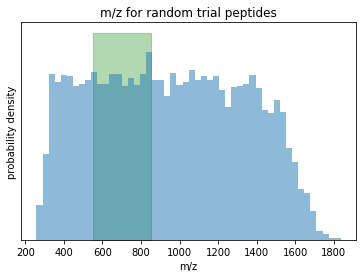

In [15]:
hist_heights = plt.hist(mz_for_random_peptides, bins=50, alpha=0.5)[0];
plt.ylabel('probability density')
plt.yticks([])
plt.xlabel('m/z')
plt.title('m/z for random trial peptides')
print('Plotted.')
print('\n')

print('Highlighting the desired m/z range constraint on the figure...')
#plt.vlines([min_mz, max_mz], 0, max(hist_heights)*1.1)
plt.fill_between([min_mz, max_mz], [0]*2, [max(hist_heights)*1.1]*2, color='green', alpha=0.3)
print('Highlighted.')
print('\n')

print('Saving figure as "m-z-for-random-trial-peptides.png" in current directory...')
plt.savefig('m-z-for-random-trial-peptides.png',dpi=300,bbox_inches='tight')
print('Saved.')
print('\n')

#plt.show()
plt.close()

#plt.fill_between([min(mz_for_random_peptides), min_mz], [0]*2, [max(hist_heights)]*2, color='grey', alpha=0.3)
#plt.fill_between([max_mz, max(mz_for_random_peptides)], [0]*2, [max(hist_heights)]*2, color='grey', alpha=0.3)

### 4.5 Plot scatter of m/z vs. length for random trial peptides.

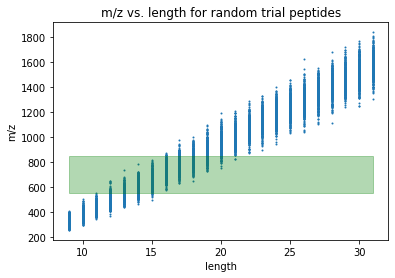

In [16]:
print('Plotting scatter of m/z vs. length for random trial peptides....')
plt.scatter(lengths, mz_for_random_peptides, s=1)
plt.title('m/z vs. length for random trial peptides')
plt.xlabel('length')
plt.ylabel('m/z')
print('Plotted.')
print('\n')

print('Highlighting the desired m/z range constraint on the figure...')
#plt.hlines([min_mz, max_mz], min(lengths), max(lengths))
plt.fill_between([min(lengths), max(lengths)], [max_mz]*2, [min_mz]*2, color='green', alpha=0.3)
print('Highlighted.')
print('\n')

print('Saving figure as "m-z-vs.-length-for-random-trial-peptides.png" in current directory...')
plt.savefig('m-z-vs.-length-for-random-trial-peptides.png',dpi=300,bbox_inches='tight')
print('Saved.')
print('\n')
#plt.show()
plt.close()

## 5. Generate library of random peptides that satisfy all constraints.

In [17]:
print('Generating library of random peptides that satisfy all the constraints...')
# generate library of random peptides that satisfy all the constraints
np.random.seed(0)
library = generate_library(library_size=100,
                          sample_from_trial_distribution=sample_from_trial_distribution,
                          check_constraints=satisfies_all_constraints)

  0%|          | 529/1000000000 [00:02<1072:47:38, 258.93it/s, current library size=100, current yield percentage=18.8]

target library size achieved! terminating early


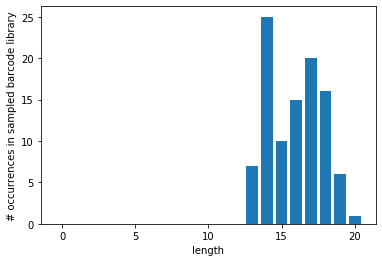

In [18]:
lengths = list(map(len, library))

print('\n')
print('Plotting distribution of peptide lengths in the library...')
plt.bar(np.arange(max(lengths)+1), np.bincount(lengths))
plt.xlabel('length')
plt.ylabel('# occurrences in sampled barcode library')
plt.xticks(np.arange(max(lengths) + 2)[::5])
#plt.show()
print('Plotted.')
print('\n')

print('Saving figure as "sample-librar-length.png" in current directory...')
plt.savefig('sample-librar-length.png', dpi=300,bbox_inches='tight')
print('Saved.')
print('\n')
plt.close()

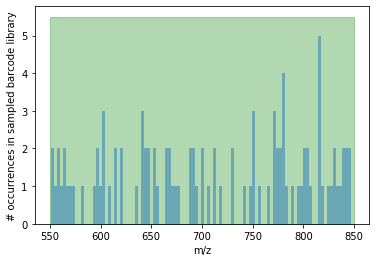

In [19]:
print('Calculating m/z values for peptides in library...')
mz_for_library_peptides = np.array(list(map(lambda p: compute_mz(digest(p),pH), library)))
print('Calculated')
print('\n')

print('Plotting distribution of m/z values for peptides in library...')
hist_heights = plt.hist(mz_for_library_peptides, bins=100, alpha=0.5)[0];
plt.xlabel('m/z')
plt.ylabel('# occurrences in sampled barcode library')
print('Plotted.')
print('\n')

print('Highlighting the desired m/z range constraint on the figure...')
plt.fill_between([min_mz, max_mz], [0]*2, [max(hist_heights)*1.1]*2, color='green', alpha=0.3)
print('Highlighted.')
print('\n')
#plt.show()

print('Saving figure as "sample-librar-m-z.png" in current directory...')
plt.savefig('sample-librar-m-z.png', dpi=300,bbox_inches='tight')
print('Saved.')
print('\n')
plt.close()

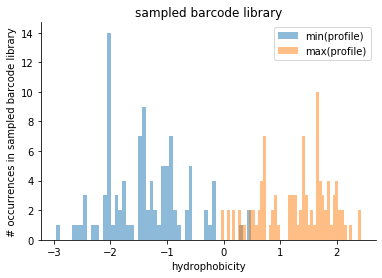

In [20]:
print('Calculating hydrophobicity profiles for peptides in library...')
hydrophobicity_profiles = list (map(compute_hydrophobicity_profile,library))
min_hydrophobicities = list (map(np.min,hydrophobicity_profiles))
max_hydrophobicities = list (map(np.max,hydrophobicity_profiles))
print('Calculated.')
print('\n')

print('Plotting distribution of hydrophobicity profiles for peptides in library...')
ax = plt.subplot(111)
plt.hist(min_hydrophobicities, bins = 50, alpha = 0.5, label = 'min(profile)');
plt.hist(max_hydrophobicities, bins = 50, alpha = 0.5, label = 'max(profile)');
plt.xlabel('hydrophobicity')
plt.ylabel('# occurrences in sampled barcode library')
plt.legend(loc='best')
plt.title('sampled barcode library')
print('Plotted.')
print('\n')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.show()
print('Saving figure as "sample-librar-hydrophobicity.png" in current directory...')
plt.savefig('sample-librar-hydrophobicity.png',dpi=300,bbox_inches='tight')
print('Saved.')
print('\n')
plt.close()

## 6. Save data in csv file.

In [ ]:
print('Describing peptides...')

In [21]:
def describe_peptide(peptide):
    barcode = peptide
    tryptic = digest(peptide)
    mz_of_tryptic_digest = compute_mz(digest(peptide),pH)
    maxhyd = np.max(compute_hydrophobicity_profile(digest(peptide)))
    return ','.join([barcode,tryptic, str(mz_of_tryptic_digest), str(maxhyd)])

lines = list(map(describe_peptide, sorted(library)))

In [ ]:
print('Described.')
print('\n')

In [22]:
print('Saving peptide descriptions in "output.csv"...')

#prepare a reformatted dict containing all parameters and their values
all_params_ks_vs = all_params.items()
reformat_all_params = {str(key): str(value) for key, value in all_params_ks_vs}

#get date and time for output file
now = datetime.now()
now = now.strftime("%d/%m/%Y %H:%M:%S")
now = now.split(' ')

#write output file
with open('output.csv', 'w') as f:
    wr = csv.writer(f, dialect='excel')
    wr.writerow(['BarcodeBabel Output'])
    wr.writerow(['Date', 'Time'])
    wr.writerow([now[0], now[1]])
    wr.writerow([])
    wr.writerow(['These are the parameter assignments BarcodeBabel used.'])
    wr.writerow(['Parameters'] + list(reformat_all_params.keys()))
    wr.writerow(['Parameter Assignments'] + list(reformat_all_params.values()))
    wr.writerow([])
    wr.writerow(['Barcode Library'])
    f.writelines(['barcode, protease digest, m/z of protease digest,maximum hydrophobocity protease digest, TAT-barcode-HIS-fwd,TAT-barcode-HIS-rev\n'])
    f.writelines(['{}\n'.format(line) for line in lines])
print('Saved.')
print('\n')

In [5]:
print('BarcodeBabel completed.')

BarcodeBabel completed.
